In [1]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 14:11:36--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [     <=>            ]  19.68M  21.7MB/s    in 0.9s    

2025-06-13 14:11:37 (21.7 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [2]:
pip install Groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [4]:
Groq_api_key = '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'
client =Groq(api_key=Groq_api_key)

In [5]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [6]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}


    Provide me with only python pandas code for below natural language questions no theory, explanation is needed. Please only provide the pandas code with necessary imports which should print the result when executed:
    {natural_language_question}

    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [7]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(fixed_code, {'df': df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [8]:
df = load_data_set()

<ipython-input-5-2730963339>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-5-2730963339>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-5-2730963339>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [9]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [10]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# Consider for Analysis

In [11]:
#llama-3.3-70b-Versatile model testing

In [12]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for Christmas 2006
df_christmas_2006 = df[(df.index.year == 2006) & (df.index.month == 12) & (df.index.day == 25)]
# Group by hour and calculate the sum of Global_active_power
hourly_power_usage = df_christmas_2006['Global_active_power'].resample('H').sum()
# Find the hour with the highest power usage
max_power_hour = hourly_power_usage.idxmax()
print(max_power_hour.hour)
------------------------------------------------------------------------
Output of the code is

<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


22


<string>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


In [ ]:
execute_query("What was the average active power consumption in March 2007?","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for March 2007 and calculate average active power consumption
average_active_power = df[(df.index.year == 2007) & (df.index.month == 3)]['Global_active_power'].mean()
print(average_active_power)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


1.3186270301754073


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Extract day of the week
df['day_of_week'] = df.index.dayofweek
# Create a new column to differentiate between weekdays and weekends
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
# Group by day type and calculate mean energy usage
energy_usage = df.groupby('day_type')['Global_active_power'].mean()
# Plot the result
energy_usage.plot(kind='bar')
---------------------------------------------------------------

<string>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


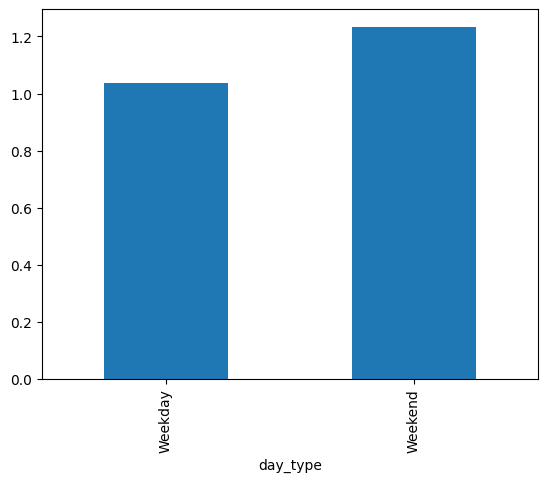

In [ ]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","llama-3.3-70b-Versatile",df)

In [ ]:
execute_query("Find days where total energy consumption exceeded 5 kWh.","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Find days where total energy consumption exceeded 5 kWh
df['Global_active_power'] = df['Global_active_power'] * 1000 / 60  # Convert to kWh
daily_energy_consumption = df['Global_active_power'].resample('D').sum()
days_exceeded_5_kwh = daily_energy_consumption[daily_energy_consumption > 5]
print(days_exceeded_5_kwh)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2006-12-16    20152.933333
2006-12-17    56507.666667
2006-12-18    36730.433333
2006-12-19    27769.900000
2006-12-20    37095.800000
                  ...     
2010-11-22    34025.600000
2010-11-23    26292.266667
2010-11-24    29937.466667
2010-11-25    23852.733333
2010-11-26    24801.733333
Name: Global_active_power, Length: 1433, dtype: float64


In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007.","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of January 2007
df_filtered = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]
# Plot the energy usage trend
plt.figure(figsize=(10,6))
------------------------------------------------------------------------
Output of the code is:



<string>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


<Figure size 1000x600 with 0 Axes>

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day.","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
# Load and preprocess data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of January 2007
df_filtered = df[(df.index.year == 2007) & (df.index.month == 1) & (df.index.day <= 7)]
# Aggregate data by day
df_aggregated = df_filtered['Global_active_power'].resample('D').mean()
# Visualize the energy usage trend
plt.figure(figsize=(10,6))
------------------------------------------------------------------------
Output of the code is:



<string>:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


<Figure size 1000x600 with 0 Axes>

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2007","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of February 2007
df_filtered = df[(df.index.year == 2007) & (df.index.month == 2) & (df.index.day <= 7)]
# Group by day and calculate average voltage
average_voltage = df_filtered['Voltage'].resample('D').mean()
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64


In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?.","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load the preprocessed dataset
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
# Preprocess the dataset
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Calculate the correlation between global active power and sub-metering values
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print the correlation matrix
print(correlation)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3             1.000000  


------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
# Preprocess the dataset
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Calculate correlation between global active power and sub-metering values
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Print the correlation matrix
print(correlation)
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', square=True)
# Visualize the relationship between global active power 

<string>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.484401        0.434569   
Sub_metering_1                  0.484401        1.000000        0.054721   
Sub_metering_2                  0.434569        0.054721        1.000000   
Sub_metering_3                  0.638555        0.102571        0.080872   

                     Sub_metering_3  
Global_active_power        0.638555  
Sub_metering_1             0.102571  
Sub_metering_2             0.080872  
Sub_metering_3             1.000000  


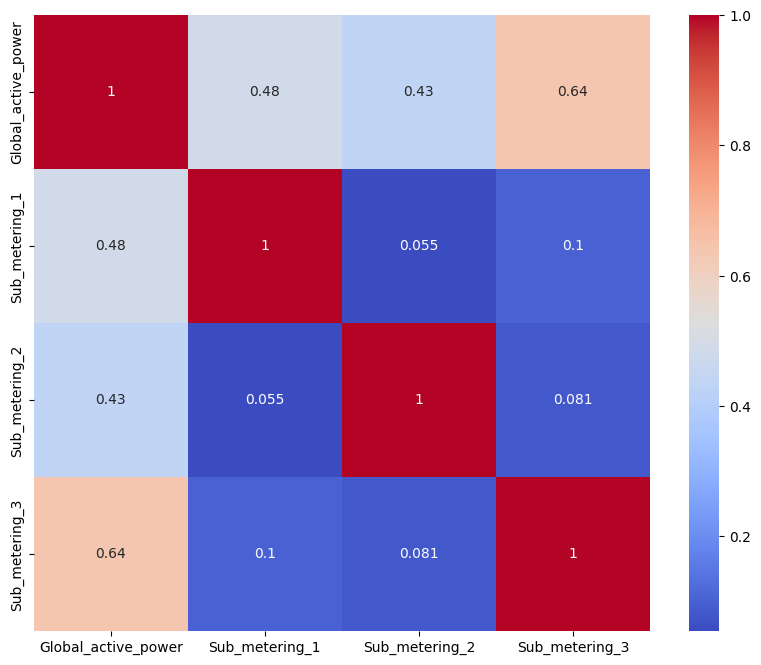

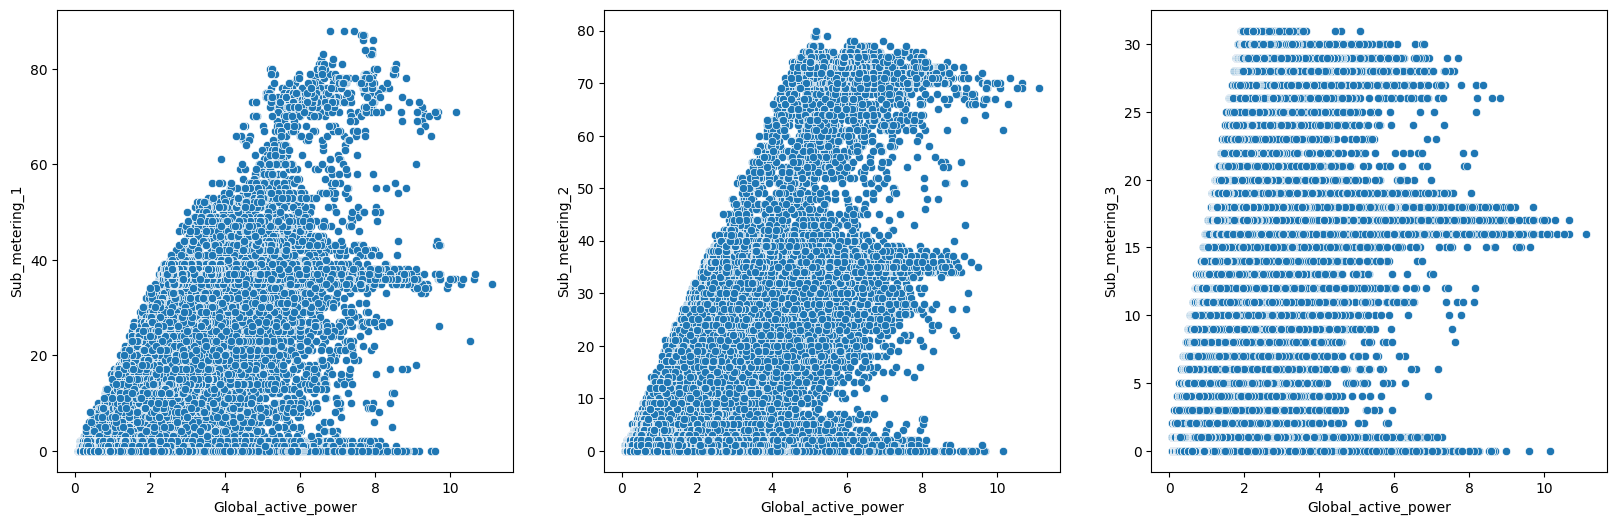

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","llama-3.3-70b-Versatile",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for the first week of February 2008
df_filtered = df[(df.index.year == 2008) & (df.index.month == 2) & (df.index.day <= 7)]
# Group by day and calculate average voltage
average_voltage = df_filtered['Voltage'].resample('D').mean()
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


In [ ]:
execute_query("Find days where energy consumption exceeded 2 kWh in 2008","llama-3.3-70b-Versatile",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Load and preprocess the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
# Filter data for 2008
df_2008 = df[df.index.year == 2008]
# Calculate daily energy consumption
daily_consumption = df_2008['Global_active_power'].resample('D').sum() / 1000  # Convert to kWh
# Find days where energy consumption exceeded 2 kWh
days_exceeded = daily_consumption[daily_consumption > 2]
print(days_exceeded)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


datetime
2008-01-01    2.759738
2008-01-04    2.291852
2008-01-05    2.183248
2008-01-08    2.043550
2008-01-12    2.871408
                ...   
2008-12-17    2.098786
2008-12-20    2.242502
2008-12-21    2.643610
2008-12-22    2.015808
2008-12-27    2.972164
Name: Global_active_power, Length: 74, dtype: float64
